In [3]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

In [4]:
# setting configurations
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# linking google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing data
df = pd.read_csv('/content/drive/MyDrive/Iowa Liquor /Prepared Data/daily_sales.csv', index_col=0)
df.head()

,Sale (Dollars)
Date,
01/03/2012,1012493.81
01/04/2012,860053.73
01/05/2012,940194.93
01/09/2012,933835.50
01/10/2012,900077.61


In [6]:
df.shape

(2973, 1)

In [12]:
# renaming column and index
df = df.rename(columns={'Sale (Dollars)': 'sale_dollars'})
df.index.rename('date', inplace=True)

In [17]:
# convert index to datetime
df.index = pd.to_datetime(df.index)

# group by month
df_month = df.resample('M').sum()

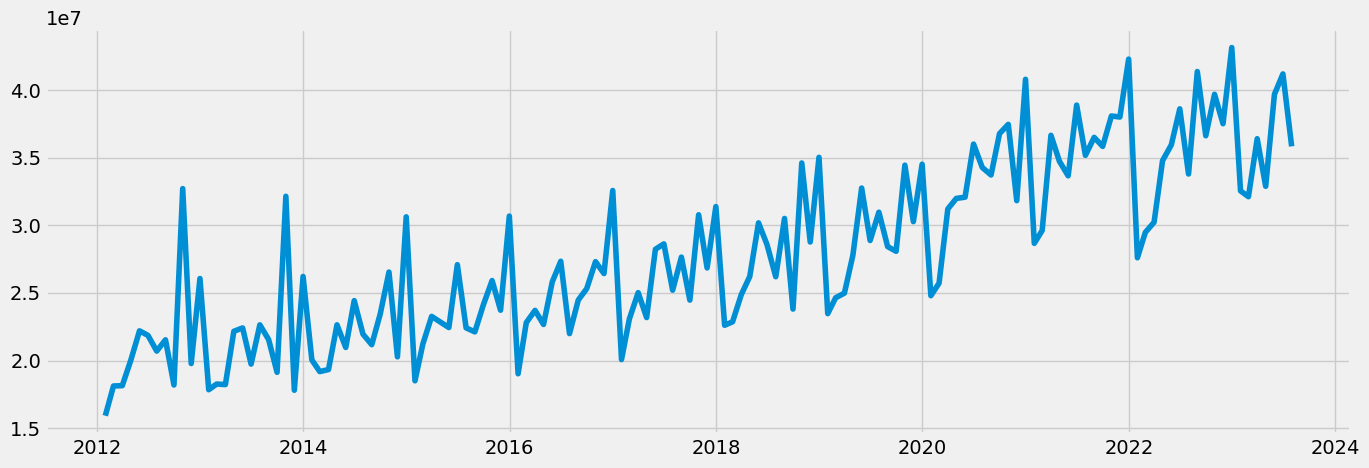

In [18]:
# plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_month)

In [19]:
# check for missing values
df_month.isnull().sum()

sale_dollars    0
dtype: int64

In [21]:
# check for duplicates
dups = df_month.duplicated()
dups.sum()

0

In [23]:
# decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_month, model='additive')

In [24]:
from pylab import rcParams # this will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

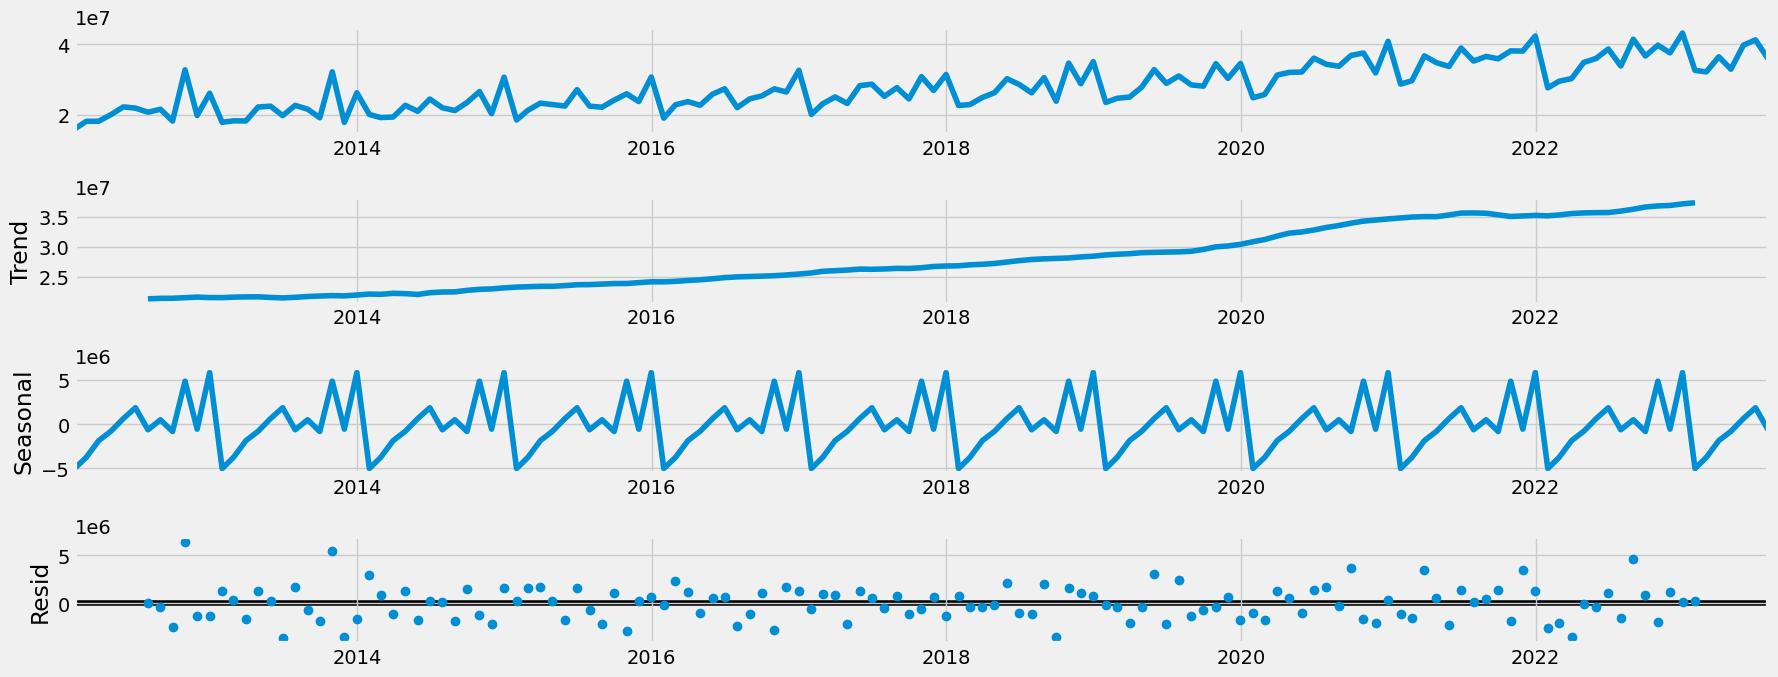

In [25]:
# plot the separate components
decomposition.plot()
plt.show()

In [30]:
from statsmodels.tsa.stattools import adfuller # import the adfuller() function

def dickey_fuller(timeseries): # define the function
    # perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# apply the test using the function on the time series
dickey_fuller(df_month['sale_dollars'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.048224
p-value                          0.994750
Number of Lags Used             14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


p-value: this is the probability that the current result would be the same if the null hypothesis were true. If the p-value is below a threshold (commonly 0.05), then the null hypothesis is rejected and the time series is considered stationary. Here, the p-value is 0.994750, which is greater than 0.05, so we fail to reject the null hypothesis. We can conclude that the series is non-stationary based on this test.

Critical Value (1%, 5%, 10%): These values are used to judge whether the test statistic is large enough (in absolute terms) to reject the null hypothesis. If the test statistic is less than the critical value, we can reject the null hypothesis and say that the series is stationary. Here, all the critical values are less than the test statistic, which further supports the conclusion that the series is non-stationary.

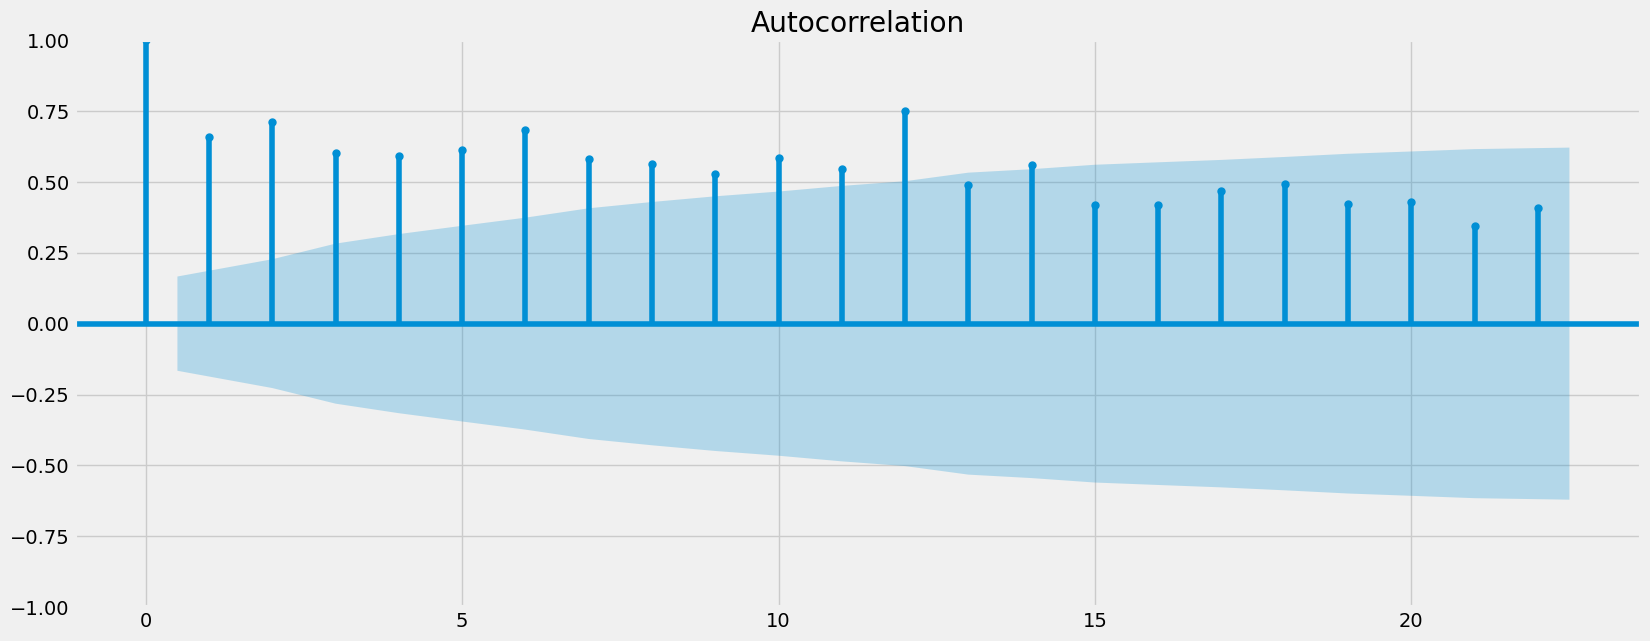

In [32]:
# check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # import the autocorrelation and partial correlation plots
plot_acf(df_month)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means that the lags are significantly correlated with each other. And when there are many lags beyond this interval, it can deduced that the data is non-stationary. As evident from the above image, the time series has quite a few lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test.

In [33]:
data_diff = df_month - df_month.shift(1) # the df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [34]:
data_diff.dropna(inplace = True) # remove the missing values that came about as a result of the differencing.
# need to remove these to run the Dickey-Fuller test.

In [35]:
data_diff.head()

,sale_dollars
date,
2012-02-29,2199909.85
2012-03-31,23441.68
2012-04-30,1865351.22
2012-05-31,2188624.27
2012-06-30,-334618.17


In [36]:
data_diff.columns

Index(['sale_dollars'], dtype='object')

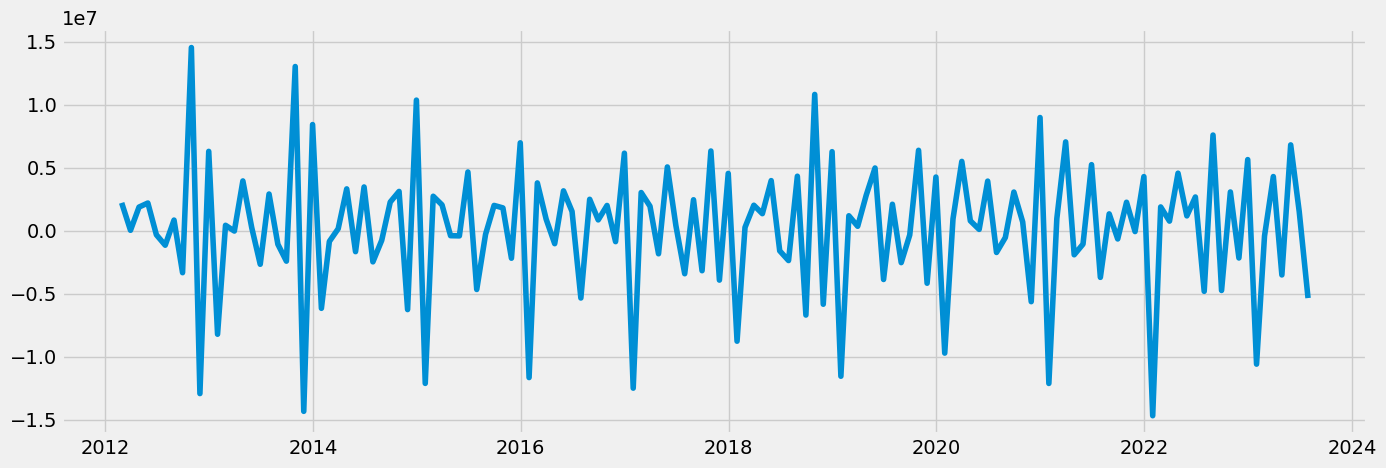

In [37]:
# check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [38]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.836810
p-value                          0.002552
Number of Lags Used             13.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


Test Statistic: The test statistic value is -3.836810. It's the output of the Dickey-Fuller test. The more negative this value is, the stronger the rejection of the null hypothesis that the time series is non-stationary.

p-value: The p-value here is 0.002552. In the context of hypothesis testing, a p-value is the probability of observing your data (or data more extreme) given that the null hypothesis is true. A common threshold for significance is 0.05. If the p-value is below 0.05, as it is in this case, we reject the null hypothesis. Here, the p-value is significantly less than 0.05, so we would reject the null hypothesis and conclude that the series is stationary.

Critical Value (1%, 5%, 10%): These values are used to compare with the test statistic to decide whether to reject the null hypothesis. The critical values depend on the confidence levels. If the test statistic is less than the critical value, we reject the null hypothesis. Here, the test statistic of -3.836810 is less than all the provided critical values at 1%, 5%, and 10% levels, indicating strong evidence against the null hypothesis.

So, based on this output, the time series is stationary because the test statistic is less than the critical values and the p-value is less than 0.05, allowing us to reject the null hypothesis of a unit root (i.e., the series being non-stationary).

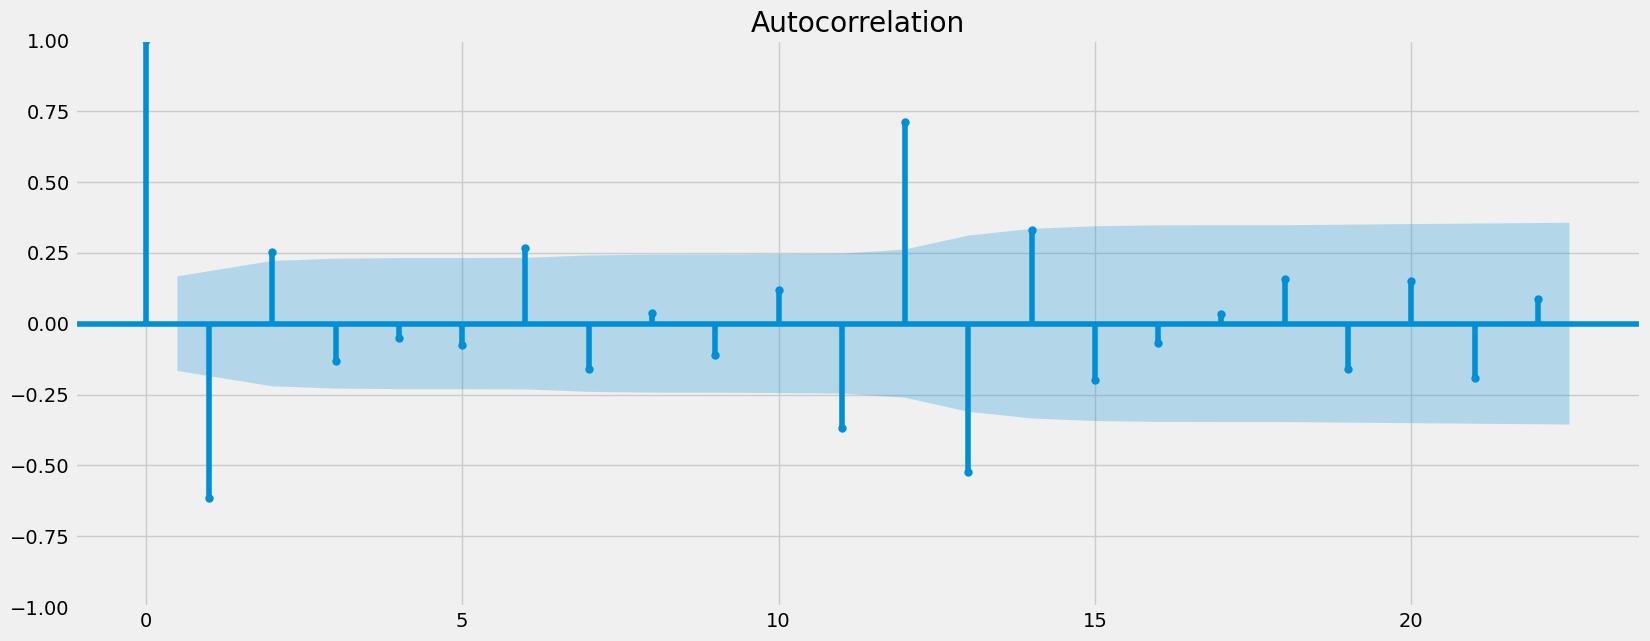

In [39]:
plot_acf(data_diff)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means that the lags are significantly correlated with each other. And when there are many lags beyond this interval, it can deduced that the data is non-stationary. As evident from the above image, the differenced time series now has minimal lines falling outside the blue area. This means there’s not a lot of autocorrelated data and the set is now stationary, which supports the result of the second Dickey-Fuller test.